# ECCO Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [55]:
from dask.distributed import Client

client = Client("tcp://10.32.2.76:38511")
client

Client Scheduler: tcp://10.32.2.76:38511 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 18 Cores: 36 Memory: 207.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [4]:
ds_ll = faces_dataset_to_latlon(ds)

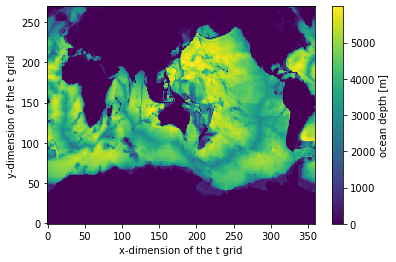

In [35]:
ds_ll.Depth.plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


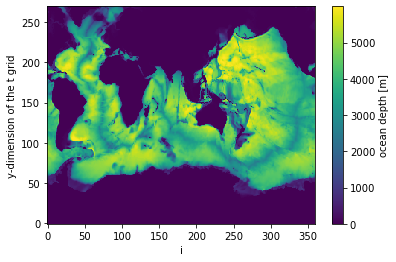

In [31]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=50).drop('i').plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2793: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


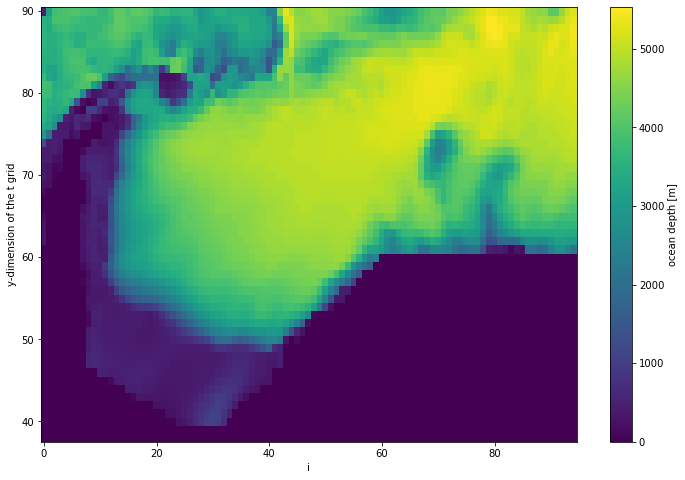

In [66]:
ds_ll.Depth.roll(i=50).drop('i').sel(i=slice(20, 115), j=slice(38, 90)).plot(figsize=(12,8))

In [34]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [37]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
left_lon = 20
right_lon = 115
lower_lat = 38
upper_lat = 90

In [68]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

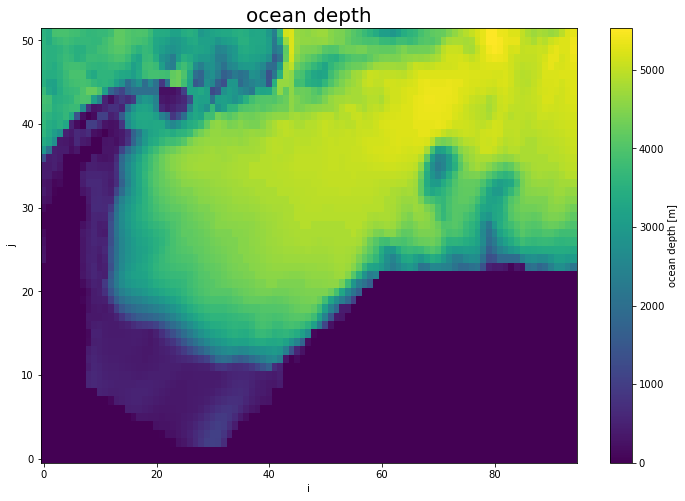

In [69]:
coords.Depth.sel(**lat_range, **lon_range).plot(figsize=(12,8))
plt.title('ocean depth', fontsize=20);

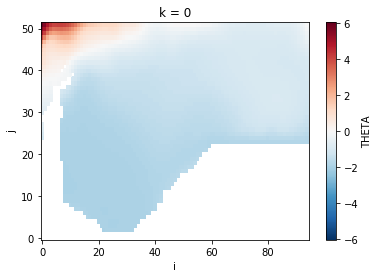

In [70]:
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

In [50]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

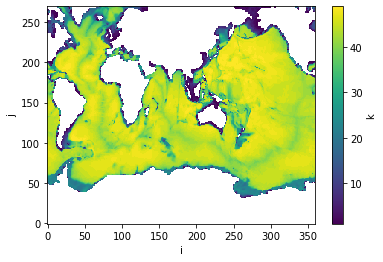

In [51]:
depth_max.plot()

In [71]:
bottom_temp = ds.THETA.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))

In [72]:
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range)

In [73]:
bottom_temp_wg.load()

<xarray.DataArray 'THETA' (j: 52, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.32238117,  0.3077251 ,  0.27641547, ..., -0.6289636 ,
        -0.6222346 , -0.6355328 ],
       [ 0.4067965 ,  0.51341385,  0.33070716, ..., -0.62511224,
        -0.6200601 , -0.6337652 ],
       [ 0.55277085,  0.5900271 ,  0.35671085, ..., -0.6171231 ,
        -0.6160381 , -0.63242555]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 46 46 46 46 46 46 47 47 48
Dimensions without coordinates: j, i

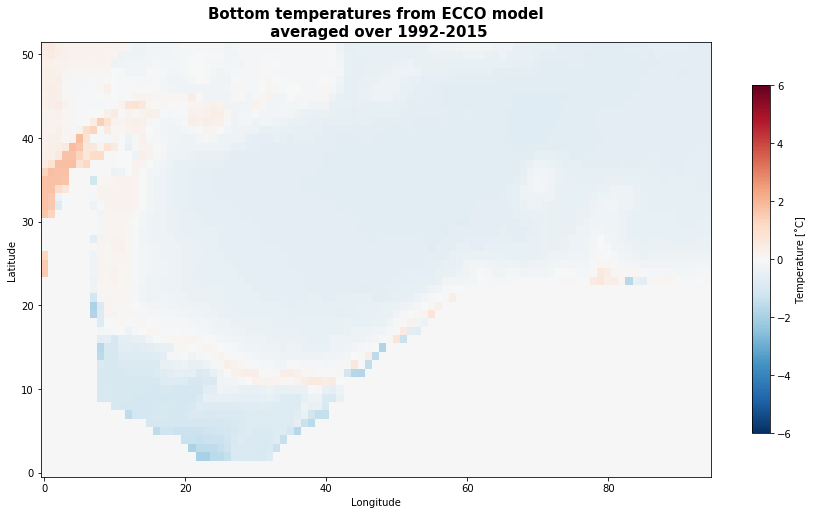

In [98]:
bottom_temp_wg.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=6)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

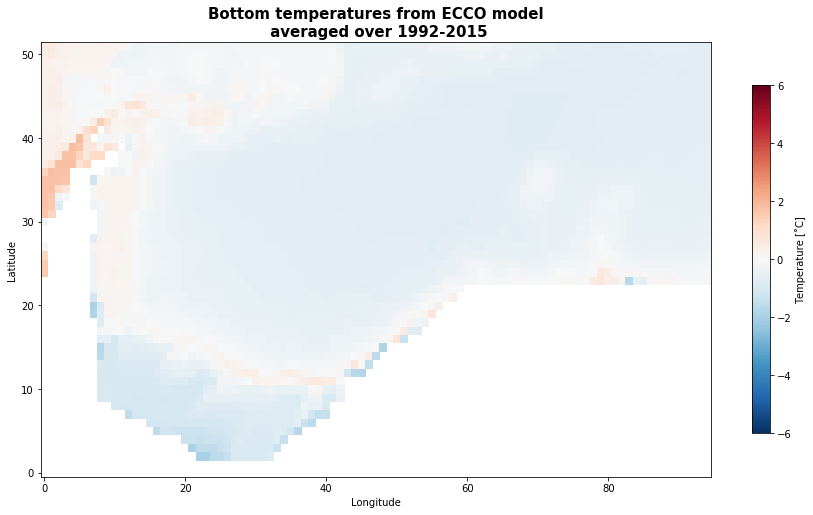

In [75]:
bottom_temp_wg.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, cmap='RdBu_r', vmax=6)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');

## Bottom Salinity

In [76]:
bottom_slt = ds.SALT.mean(dim='time').isel(k=depth_max.fillna(0.).astype('i4'))

In [77]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range)

In [78]:
bottom_slt_wg.load()

<xarray.DataArray 'SALT' (j: 52, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.70811 , 34.70702 , 34.70578 , ..., 34.672806, 34.671665,
        34.67085 ],
       [34.709854, 34.711884, 34.707447, ..., 34.672657, 34.671444,
        34.670635],
       [34.712265, 34.712845, 34.70824 , ..., 34.672043, 34.670845,
        34.670425]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 46 46 46 46 46 46 47 47 48
Dimensions without coordinates: j, i

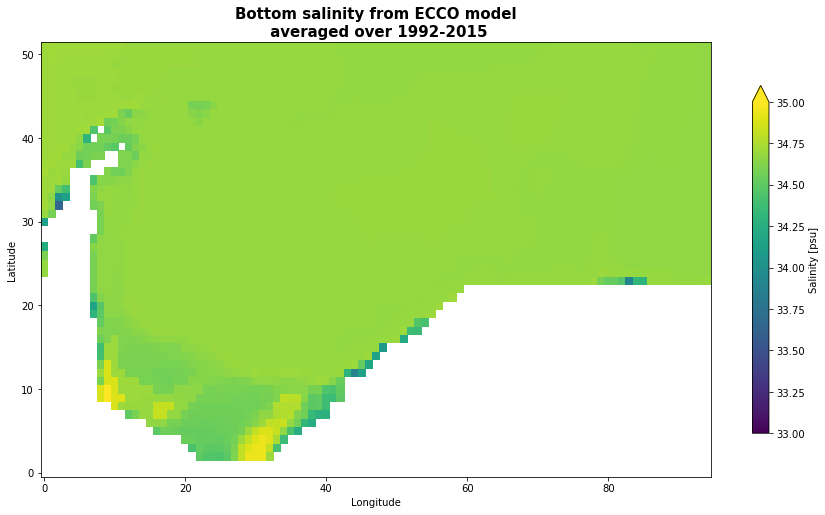

In [79]:
bottom_slt_wg.where(surface_mask).plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'}, vmin=33, vmax=35)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=15, weight='bold');